In [1]:
'''
Author: Samantha Piekos
Date: 4/8/19
Title: bipartite_graph
Description: Takes in trios and functional information regarding the non-neural ectoderm functionality
and generates bipartite graphs with this information encoded. The components can then be explored to
examine potential regulatory networks. The structure of the graph can also be examined.
'''

'\nAuthor: Samantha Piekos\nDate: 4/8/19\nTitle: bipartite_graph\nDescription: Takes in trios and functional information regarding the non-neural ectoderm functionality\nand generates bipartite graphs with this information encoded. The components can then be explored to\nexamine potential regulatory networks. The structure of the graph can also be examined.\n'

In [2]:
# import packages
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

In [3]:
def writeGenes2List(filepath, index):
    '''
    Take in a file and write the gene symbols of genes expressed in the non-neural ectoderm to a list.
    
    @filepath   file path to file containing a list of gene symbols of interest
    @index      index position of the gene symbols in the file
    @return     list of gene symbols
    '''
    genes = []
    with open(filepath, 'r') as file:
        genes = []
        for line in file:
            line = line.strip('\r\n').split('\t')
            genes.append(line[index])
    file.close()
    return(genes)

def writeLoops2List(filepath, resolution, FC_cutoff, FDR_cutoff):
    '''
    Take in a file and write loop coordinates to a list.
    
    @filepath   file path to the file containing the loop coordinates of interest
    @resolution resolution of the loops
    @FC_cutoff  cutoff value for the FC of the loops to include
    @FDR_cutoff cutoff value for the FDR of the loops to include
    @return     list of loop coordinates
    '''
    loop_list = []
    with open(filepath, 'r') as file:
        for line in file:
            line = line.strip('\r\n').split('\t')
            loop, FC, FDR = (line[0], str(int(int(line[1])+resolution/2)),\
                             str(int(int(line[4])+resolution/2))), abs(float(line[7])), float(line[11])
            if FC > FC_cutoff and FDR < FDR_cutoff:
                loop_list.append(loop)
    file.close()
    return(loop_list)

def writeLoops2List_v2(filepath, FC_cutoff, FDR_cutoff):
    '''
    Take in a file and write loop coordinates to a list.
    
    @filepath   file path to the file containing the loop coordinates of interest
    @resolution resolution of the loops
    @FC_cutoff  cutoff value for the FC of the loops to include
    @FDR_cutoff cutoff value for the FDR of the loops to include
    @return     list of loop coordinates
    '''
    loop_list = []
    with open(filepath, 'r') as file:
        for line in file:
            line = line.strip('\r\n').split('\t')
            loop, FC, FDR = tuple(line[0:3]), abs(float(line[4])), float(line[8])
            if FC > FC_cutoff and FDR < FDR_cutoff:
                loop_list.append(loop)
    file.close()
    return(loop_list)

def writeFile2List(filepath):
    '''
    Take in a file and write lines to a list.
    
    @filepath   file path to file of interest
    @return     return list of lines in the file
    '''
    file_list = []
    with open(filepath, 'r') as file:
        for line in file:
            line = line.strip('\r\n').split('\t')
            file_list.append(line)
    file.close()
    return(file_list)

def write2dict(key, value, dictionary):
    '''
    Writes a key and value to a list in a dictionary in which the value is a list of values.
    
    @key          key
    @value        value to be added to a list
    @dictionary   dictionary to which the key, value pair will be added
    @return       updated dictionary
    '''
    if key in dictionary.keys() and value not in dictionary[key]:
        dictionary[key].append(value)
    elif key not in dictionary.keys():
        dictionary[key] = [value]
    return(dictionary)

def determine_gene_node_outline_color(dictionary, gene, gene_list1, gene_list2):
    '''
    Based off of the functional information known about a given gene write the node outline
    color to a dictionary in which the gene is the key and the color is the value.
    
    @dictionary   dictionary recording the color of node outline for each node
    @gene         gene node of interest
    @gene_list1   list of genes of functional interest (p63-dep)
    @gene_list2   list of genes of functional interest (ap2a-dep)
    @return       updated dictionary
    '''
    if gene in gene_list1:
        if gene in gene_list2:
            dictionary[gene] = 'lightseagreen'  # p63-dep and ap2a-dep gene
        else:
            dictionary[gene] = 'seagreen'  # p63-dep gene
    elif gene in gene_list2:
        dictionary[gene] = 'royalblue'  # ap2a-dep gene
    else:
        dictionary[gene] = 'black'  # not p63-dep nor ap2a-dep gene
    return(dictionary)

def determine_RE_node_outline_color(dictionary, RE, enhancer):
    if 'ATAC' in enhancer:
        if enhancer == 'ATAC':
            dictionary[RE] = 'black'
        if enhancer == 'mor-dep_ATAC':
            dictionary[RE] = 'silver'
        if enhancer == 'p63-dep_ATAC':
            dictionary[RE] = 'seagreen'
        if enhancer == 'TFAP2a-dep_ATAC':
            dictionary[RE] = 'royalblue'
    else:
        dictionary[RE] = 'black'
    return(dictionary)

def determine_node_shape(dictionary, gene, gene_list):
    '''
    Based off of functional information specify the node shape for a provided node in a
    dictionary with the node as the key and the shape as the value.
    
    @dictionary   dictionary recording the shape of each node
    @gene         gene node of interest
    @gene_list    list of genes of functional interest (mor-dep genes)
    @return       updated dictionary
    '''
    if gene in gene_list:
            dictionary[gene] = '^'  # mor-dep gene
    else:
        dictionary[gene] = 'o'  # not mor-dep gene
    return(dictionary)

def determine_edge_color(contact, loop_list1, loop_list2, loop_list3):
    '''
    Determine if a given contact is ap2a-dep, p63-dep, and/or mor-dep and
    return the appropriate associated color.
    
    @contact      loop to be queried
    @loop_list1   list of ap2a-dep loops
    @loop_list2   list of p63-dep loops
    @loop_list3   list of mor-dep loops
    @return       color associated with the loop dependecies
    '''
    if contact in loop_list1:
        if contact in loop_list2:
            if contact in loop_list3:
                return('cadetblue')  # ap2a-dep, p63-dep, mor-dep loop
            else:
                return('lightseagreen')  # ap2a-dep, p63-dep
        else:
            if contact in loop_list3:
                return('lightsteelblue')  # ap2a-dep, mor-dep loop
            else:
                return('royalblue')  # ap2a-dep
    elif contact in loop_list2:
        if contact in loop_list3:
            return('darkseagreen')  # p63-dep, mor-dep
        else:
            return('seagreen')  # p63-dep loop
    elif contact in loop_list3:
        return('silver')  # mor-dep loop
    return('black')  # no dependence
                

def record_edge_info(value, key, edge_width_dictionary, edge_color_dictionary, loop,\
                     loop_list1, loop_list2, loop_list3):
    '''
    Write the maximum connectivity value for chromatin loop between gene and SNP.
    
    @value        connectivity value for a chromatin loop connecting gene and SNP
    @key          gene-SNP edge
    @edge_width_dictionary   dictionary containing maximum connectivity value for each edge
    @edge_color_dictionary   dictionary containing the edge color based off of functional loop info
    @loop         loop coordinates
    @loop_list    list of loops of functional interest (ap2a-dep)
    @return       updated dictionaries (edge_with_dictionary, edge_color_dictionary)
    '''
    if key in edge_width_dictionary and value > edge_width_dictionary[key]:
        edge_width_dictionary[key] = value
        edge_color_dictionary[key] = determine_edge_color(loop, loop_list1, loop_list2, loop_list3)
    elif key not in edge_width_dictionary:
        edge_width_dictionary[key] = value
        edge_color_dictionary[key] = determine_edge_color(loop, loop_list1, loop_list2, loop_list3)
    return(edge_width_dictionary, edge_color_dictionary)

def buildColorMap(G):
    '''
    Specify the node color based off of the node-type attribute, which specifies if the node
    is a gene or the type of regulatory element in which a SNP is contained. Contains this
    information in a color_map with the node as the key and the value as the color.
    
    @G        networkx graph containing nodes of interest
    @return   color map with the node as the key and the color as the value
    '''
    node_types = nx.get_node_attributes(G,'type')
    color_map = {}
    for n in G.nodes():
    # loop through nodes; color compounds red and targets yellow; specify target names
        if node_types[n] == 'gene':
            color_map[n] = 'white'
        elif node_types[n] == 'p63':
            color_map[n] = 'seagreen' 
        elif node_types[n] == 'AP2c':
            color_map[n] ='darkorchid'
        elif node_types[n] == 'AP2c_BASU':
            color_map[n] = 'plum'
        elif node_types[n] == 'AP2a':
            color_map[n] = 'royalblue'
        elif node_types[n] == 'GATA3':
            color_map[n] = 'lightpink'
        elif node_types[n] == 'CTCF':
            color_map[n] = 'gold'
        elif node_types[n] == 'GRHL2':
            color_map[n] = 'coral'
        elif "ATAC" in node_types[n]:
            color_map[n] = 'blanchedalmond'
        else:
            print(node_types[n])
            color_map[n] = 'black'
    return(color_map)

def addToCountDict(dictionary, key, value):
    '''
    Add an item to the set of values in a dictionary.
    
    @dictionary   dictionary to which the key, value pair will be added
    @key          key to which to add the value
    @value        value to be added to a set associated with the key
    '''
    if key in dictionary:
        dictionary[key].append(value)
    else:
        dictionary[key] = [value]
    return(dictionary)

def createNodeLabelMapping(dictionary, genes):
    '''
    Create a new dictionary with the same keys as the input dictionary,
    but the value as the length of the set of the original dictionary value.
    Also, add all items in a gene set/list to dictionary as both the key
    and the value.
     
    @dictionary  dictionary from which to create the new count dictionary
    @genes       list or set of genes to add to the dictionary
    '''
    dict_labels = {}
    for key, value in dictionary.items():
        dict_labels[key] = str(len(list(set(value))))
    for item in genes:
        dict_labels[item] = item
    return(dict_labels)

def calculateEdgeWidth(connectivity):
    width = connectivity/20
    if width < 1:
        width = 1
    return(width)

In [4]:
#def main():
# write information on non-neural ectoderm gene expression to lists
expressed_genes = writeGenes2List('H9_d7_expressed_genes_list.txt', 0)
p63_dep_genes = writeGenes2List('1.5FC_d7p63WTvsd7p63KO_p0.05_proteinCodingGenes.bed', 3)
ap2a_dep_genes = writeGenes2List('ALL-2A-dep_genes.bed', 0)
mor_dep_genes = writeGenes2List('DESeq2_1.5FC_padj0.05_WTD0_vs_WTD7_genes.bed', 3)

# write information on non-neural ectoderm loops to lists
ap2a_dep_loops = writeLoops2List('ID_EdgeR_results_All_d72AKOvsd7p63WT_ALL.bed', 10000, 0.589463, 0.05)
p63_dep_loops = writeLoops2List_v2('EdgeR_results_All_d7p63KOvsd7p63WT_contact_position.txt', 0.589463, 0.05)
mor_dep_loops = writeLoops2List_v2('EdgeR_results_All_d7p63WTvsd0_contact_position.txt', 0.589463, 0.05)

# write SNP_gene_regulatoryElement trios to a list
trios = writeFile2List("all_trios.txt")

# define sets and dictionaries
nodes = set()
edges = set()
REs = set()
genes = set()
SNPs = set()
connectivity_dict = {}
RE_dis_dict = {}
group_dict = {}
TF_dep_dict = {}
shape_dict = {}
edge_color_dict = {}
RE_SNP_dict = {}
node_type_dict = {}

# loop over trios and store node, edges, and functional informations to sets and dictionaries
for line in trios:
    enhancer, gene, SNP, MAF, connectivity = line[:5]
    RE = tuple(line[11:14])
    if gene in expressed_genes:
        RE_pos = (int(line[12]) + int(line[13]))/2
        gene_pos = (int(line[6]) + int(line[7]))/2
        RE_dis = abs(RE_pos - gene_pos)
        RE_dis_dict[(RE, gene)] = RE_dis
        loop_coord = tuple(line[14:])
        nodes.add(RE)
        nodes.add(gene)
        edges.add((RE, gene))
        REs.add(RE)
        SNPs.add(SNP)
        genes.add(gene)
        node_type_dict[RE] = enhancer
        node_type_dict[gene] = 'gene'
        group_dict[gene] = 'gene'
        group_dict[RE] = 'RE'
        connectivity_dict, edge_color_dict = record_edge_info(int(connectivity), (RE, gene), connectivity_dict,\
                                             edge_color_dict, loop_coord, ap2a_dep_loops, p63_dep_loops, mor_dep_loops)
        TF_dep_dict = determine_gene_node_outline_color(TF_dep_dict, gene, p63_dep_genes, ap2a_dep_genes)
        TF_dep_dict = determine_RE_node_outline_color(TF_dep_dict, RE, enhancer)
        shape_dict = determine_node_shape(shape_dict, gene, mor_dep_genes)
        shape_dict[RE] = 's'
        RE_SNP_dict = addToCountDict(RE_SNP_dict, RE, SNP)

node_label_dict = createNodeLabelMapping(RE_SNP_dict, genes)
nodes = list(nodes)
edges = list(edges)
REs = list(REs)
genes = list(genes)
SNPs = list(SNPs)
print(edges[:5])
print('There are '+str(len(nodes))+ ' nodes')
print('There are '+str(len(edges)) + ' edges')
print('There are ' + str(len(REs)) + ' REs')
print('There are ' + str(len(genes)) + ' genes')
print('There are ' + str(len(SNPs)) + ' SNPs')

[(('chr8', '38239480', '38240075'), 'WHSC1L1'), (('chr3', '99630378', '99630725'), 'CMSS1'), (('chr7', '27140980', '27142848'), 'HOXA4'), (('chr7', '26838404', '26838956'), 'HOXA6'), (('chr12', '56390038', '56391584'), 'GDF11')]
There are 277 nodes
There are 446 edges
There are 168 REs
There are 109 genes
There are 190 SNPs


In [5]:
'''
Specify the following about the graph
    - SNP node color based off of associated binding motif
    - gene node shape off of if it is morphogen-dependent or not
    - gene node outline by if it's p63 and/or ap2a-dependent
    - edge color by if it's ap2a-dependent
    - edge distance by linear distance
    - edge width by connectivity strength
'''  
# construct initial network
G=nx.Graph()
G.add_nodes_from(nodes)
for edge in edges:
    G.add_edge(*edge, length=RE_dis_dict[edge], weight=calculateEdgeWidth(connectivity_dict[edge]), color=edge_color_dict[edge])
print(G.number_of_nodes())
print(G.number_of_edges())
# set node attributes based off of functional information
nx.set_node_attributes(G, node_type_dict, 'type')
nx.set_node_attributes(G, group_dict, 'group')
nx.set_node_attributes(G, node_label_dict, 'name')
nx.set_edge_attributes(G, connectivity_dict, 'connectivity')
nx.set_edge_attributes(G, RE_dis_dict, 'distance')
pos=nx.spring_layout(G)       
color_map = buildColorMap(G)

277
446


In [6]:
# print the number of componenets and their sizes
print(nx.number_connected_components(G))
print([len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)])

47
[33, 27, 16, 11, 11, 10, 9, 9, 7, 7, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2]


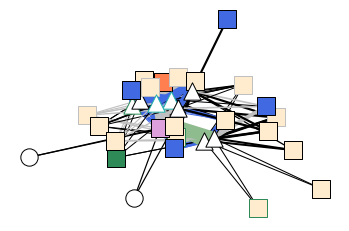

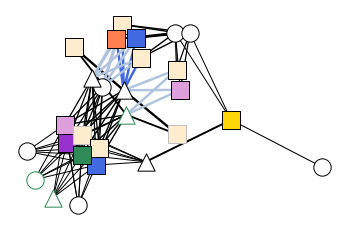

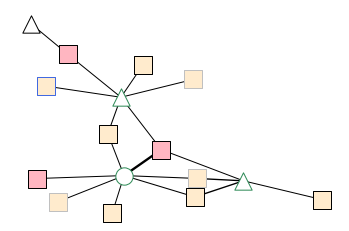

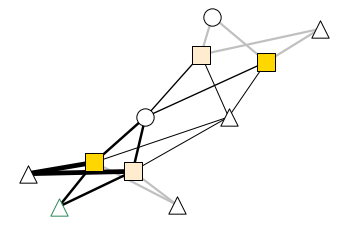

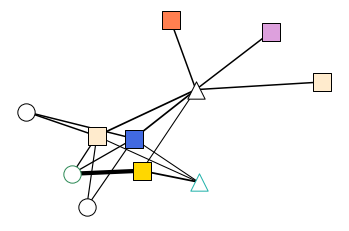

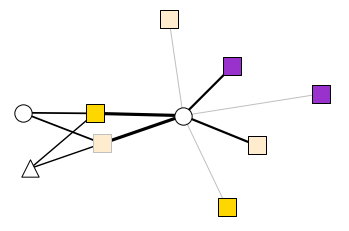

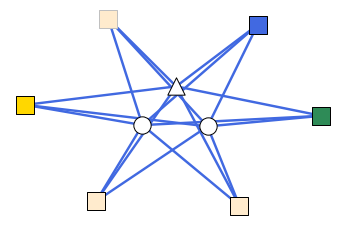

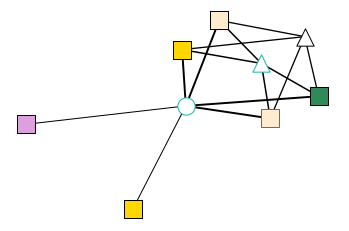

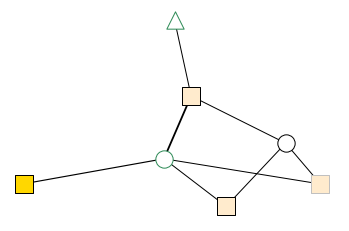

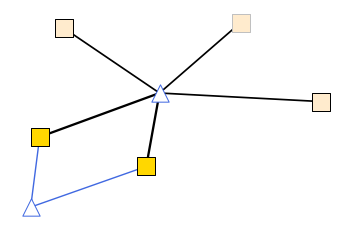

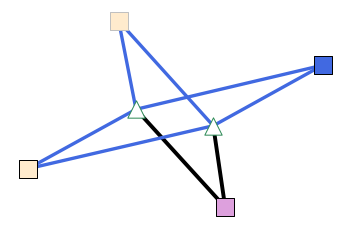

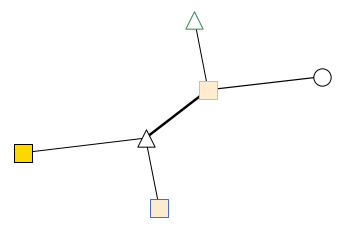

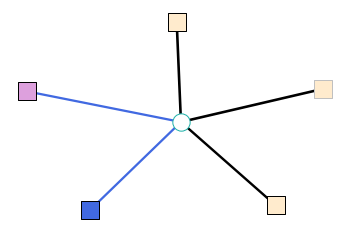

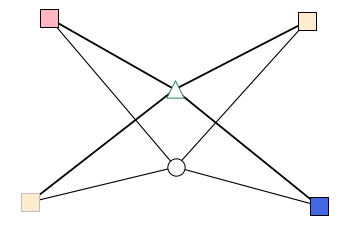

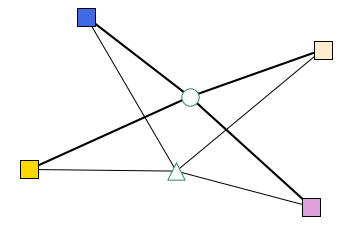

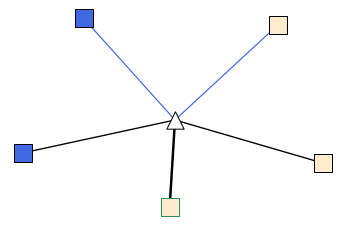

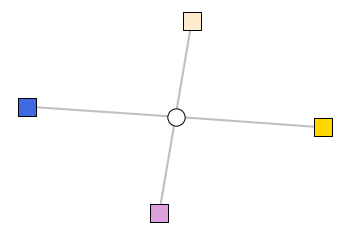

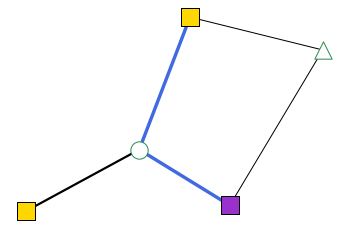

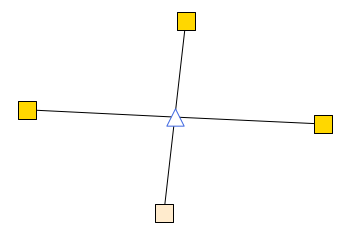

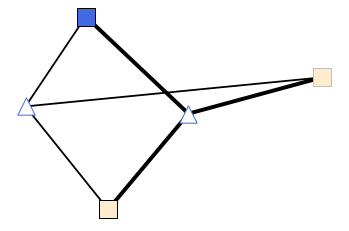

In [7]:
# plot individual components larger than 5 nodes
for c in sorted(nx.connected_components(G), key=len, reverse=True):
    c = list(c)
    if len(c) >= 5:
        sub_nodes = list(nx.node_connected_component(G, c[0]))
        S = G.subgraph(sub_nodes)
        color_map = buildColorMap(S)
        pos=nx.spring_layout(S, seed=999)
        weights = [S[u][v]['weight'] for u,v in S.edges()]
        colors = [S[u][v]['color'] for u,v in S.edges()]
        for n in S.nodes():
            node = nx.draw_networkx_nodes(S, pos=pos, node_color=color_map[n], node_shape=shape_dict[n], nodelist =[n])
            node.set_edgecolor(TF_dep_dict[n])
        nx.draw_networkx_edges(S, pos=pos, width=weights, edge_color=colors)
        plt.axis('off')
        plt.show()

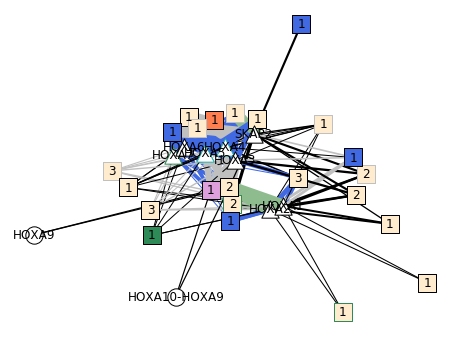

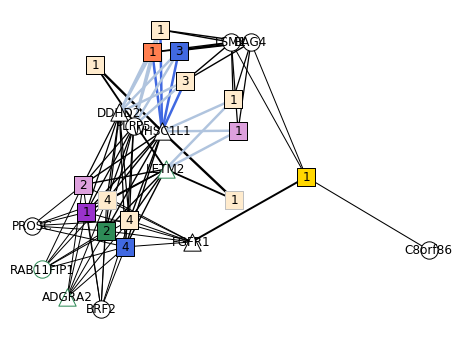

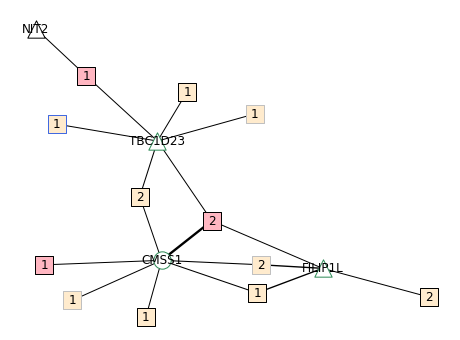

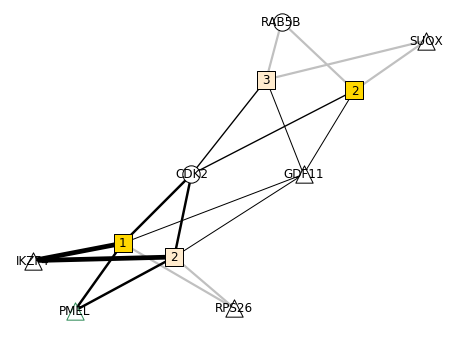

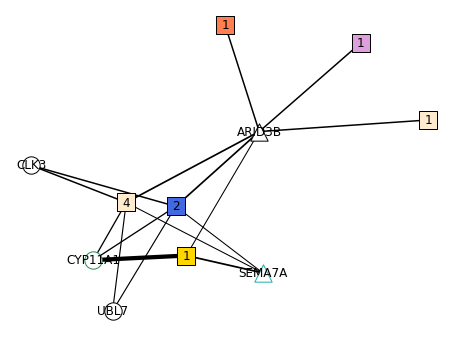

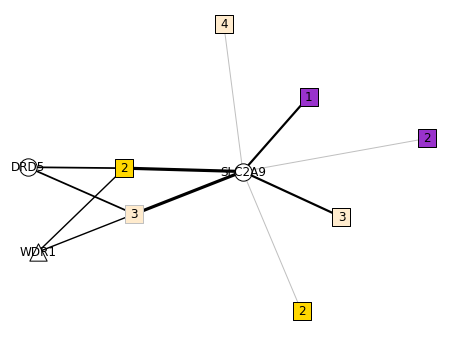

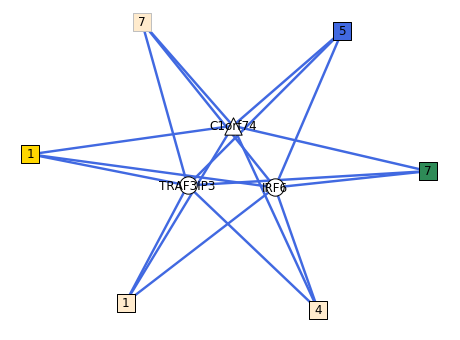

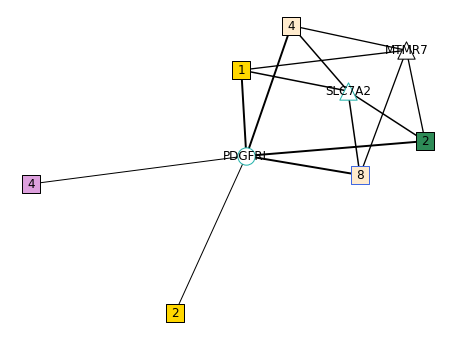

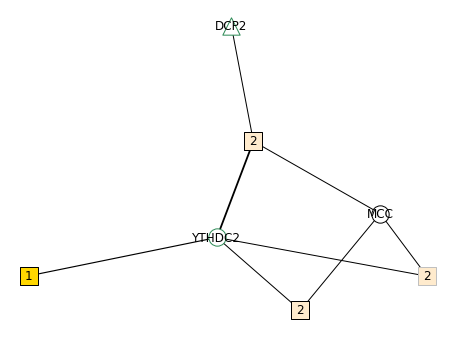

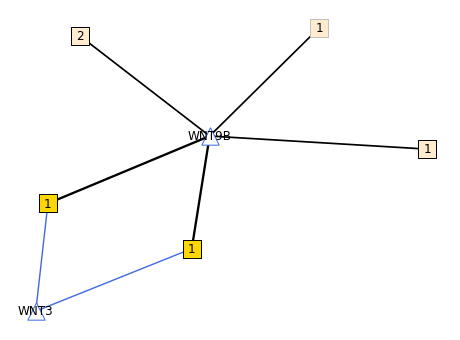

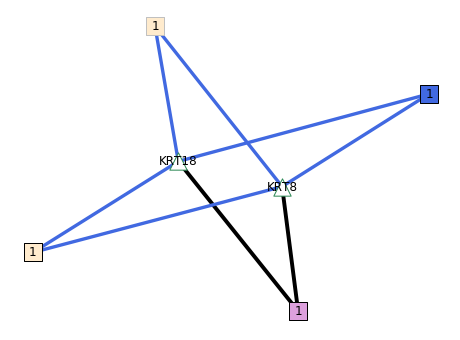

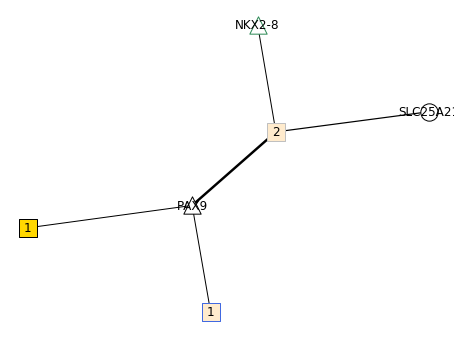

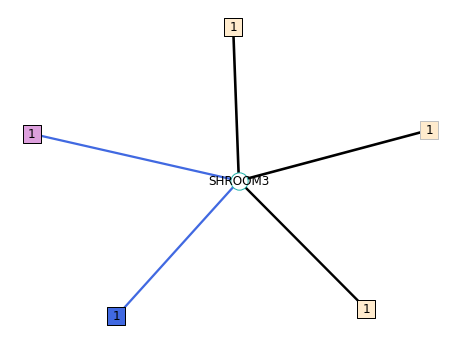

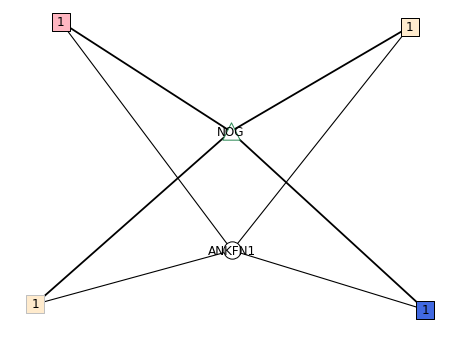

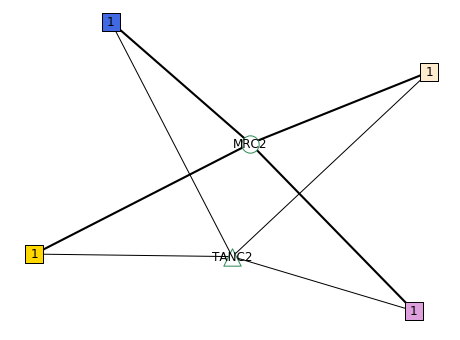

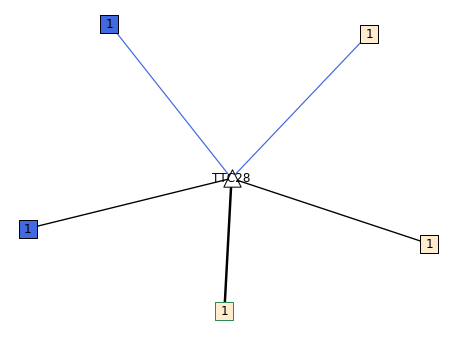

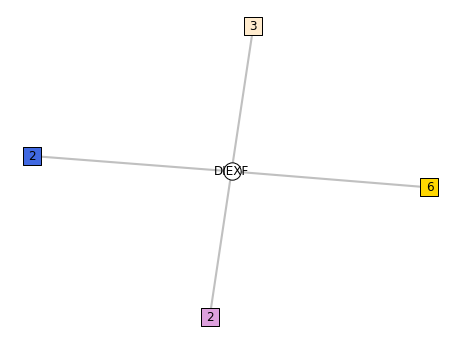

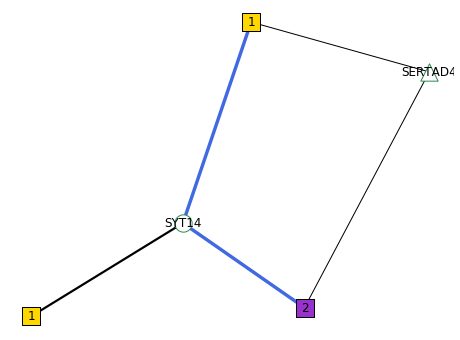

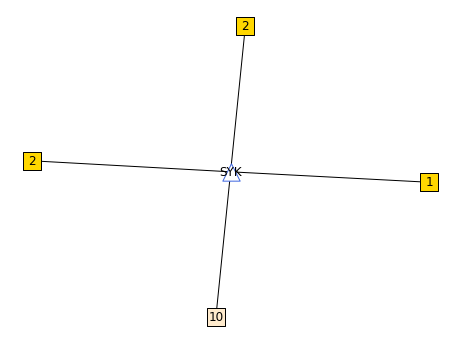

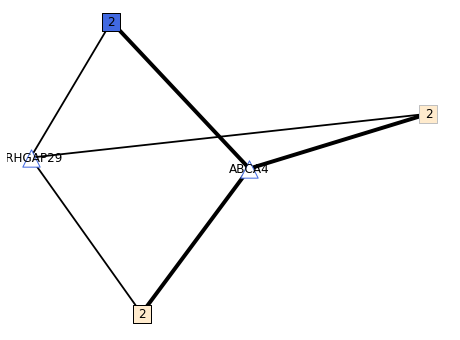

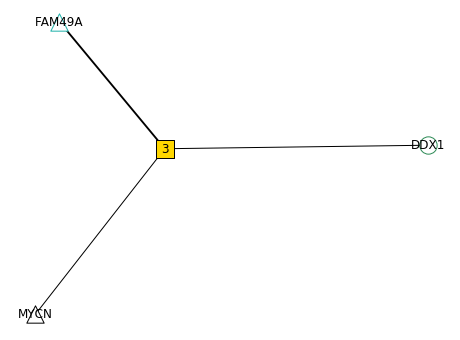

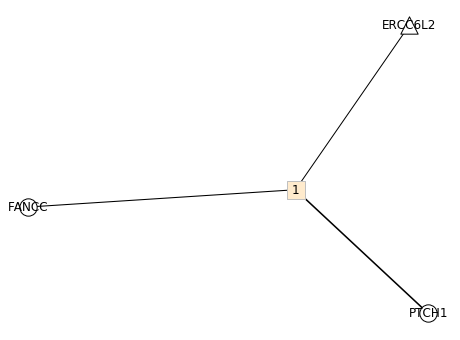

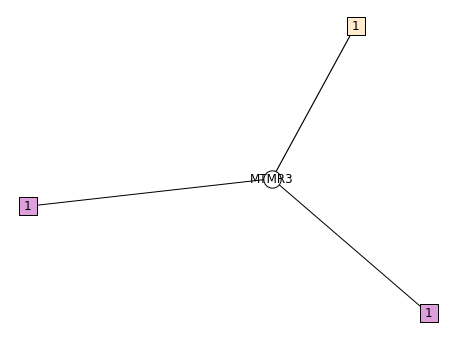

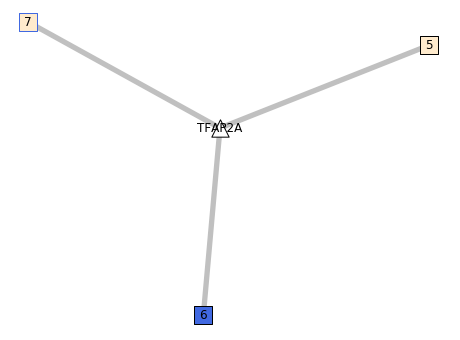

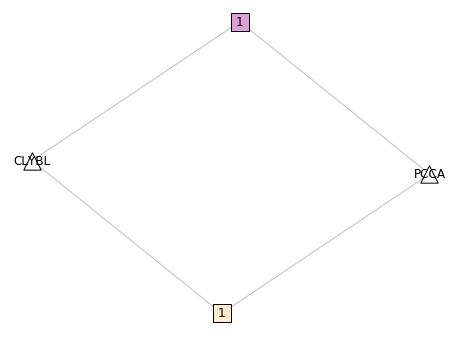

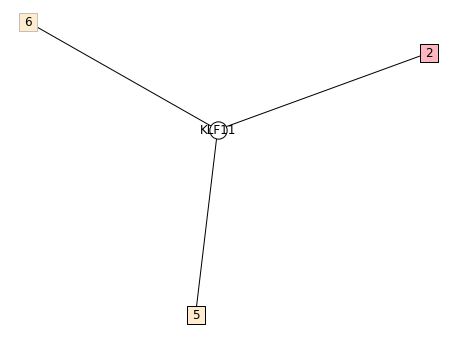

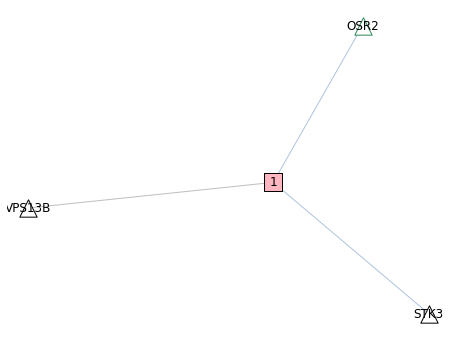

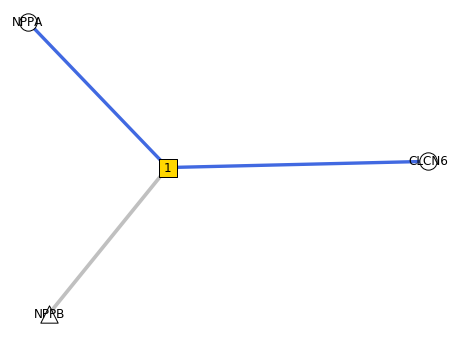

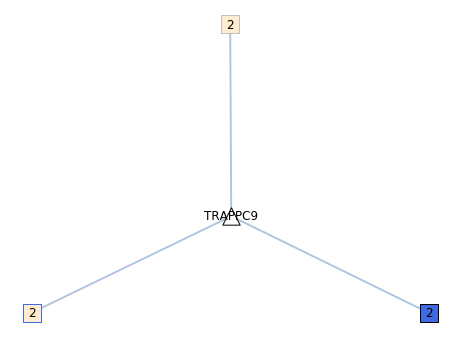

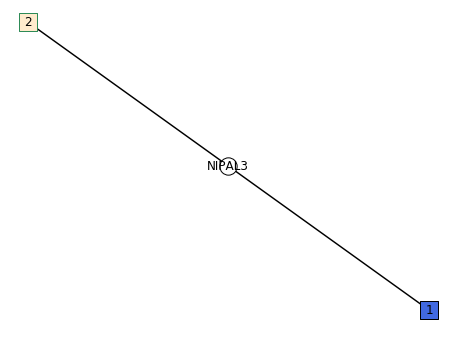

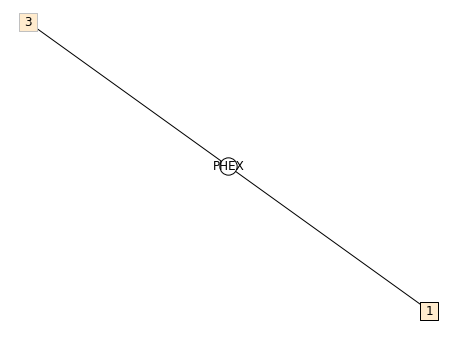

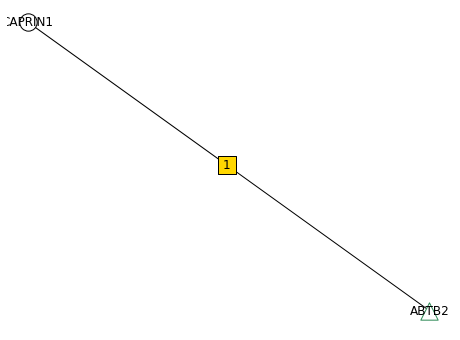

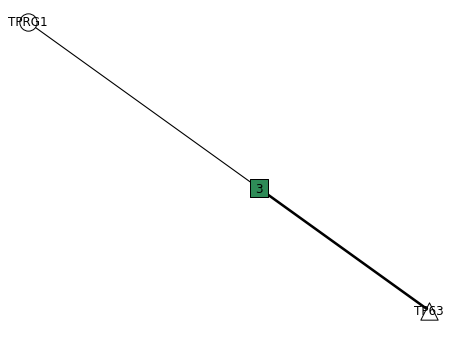

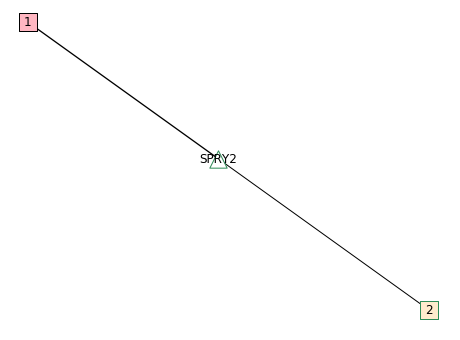

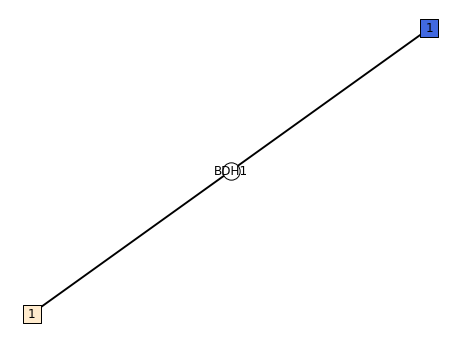

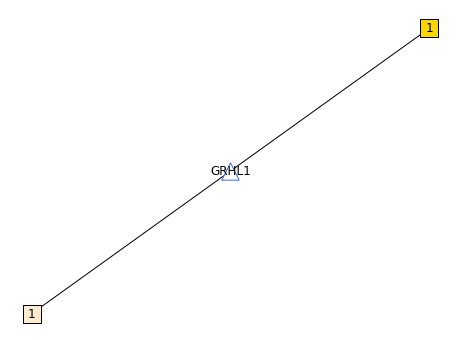

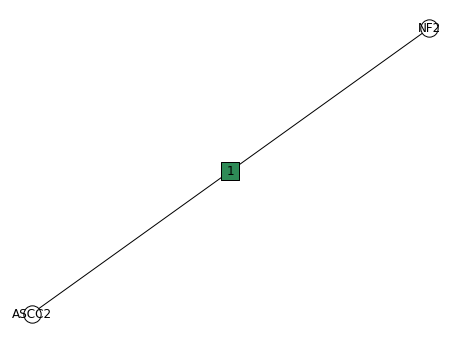

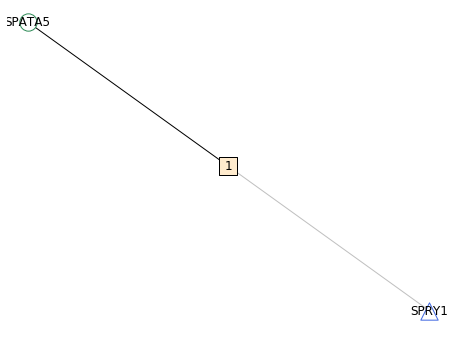

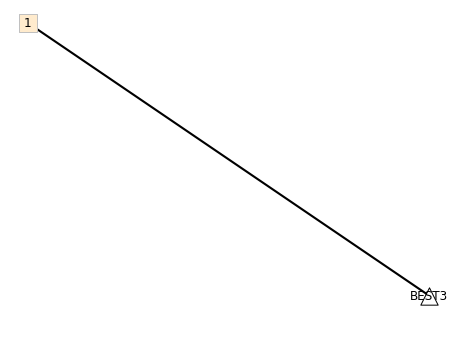

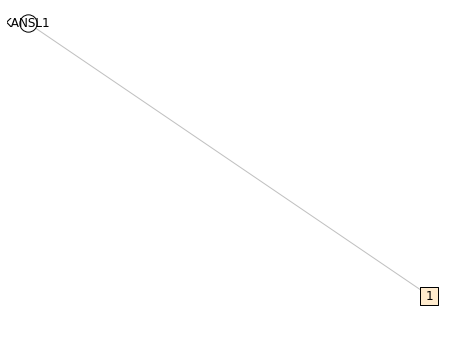

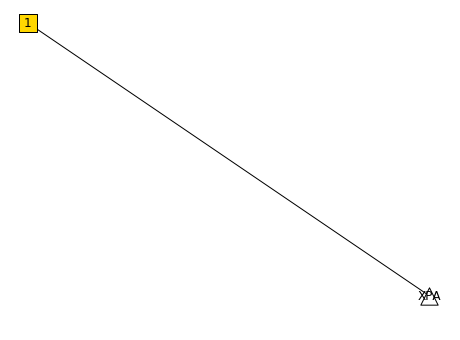

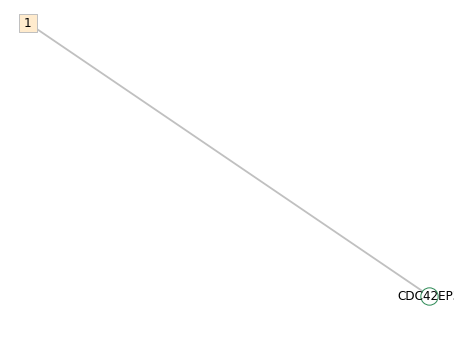

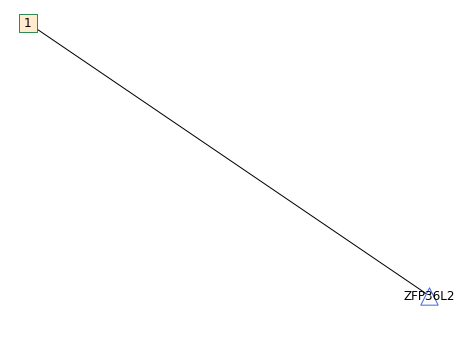

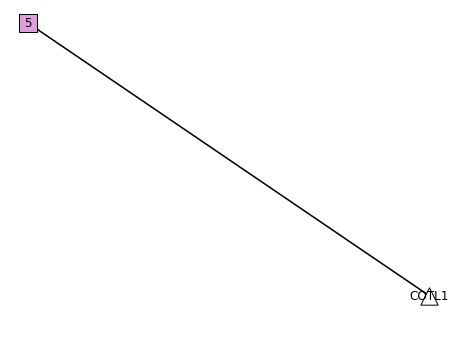

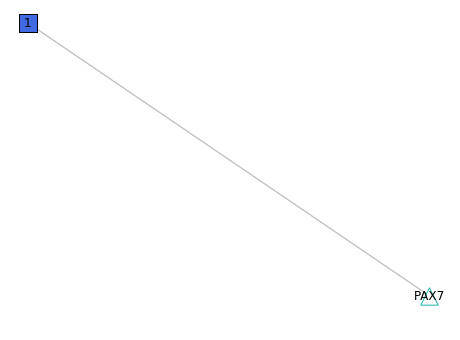

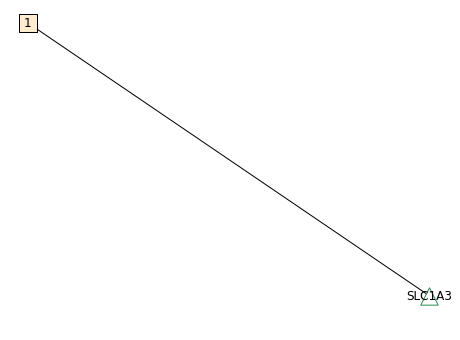

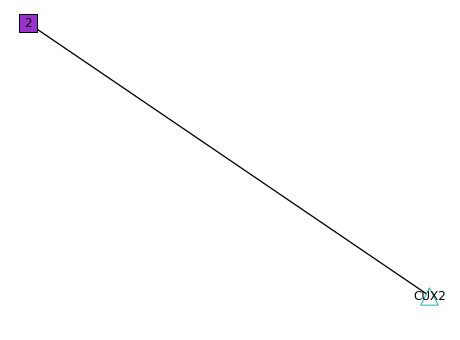

In [15]:
# plot all components with gene and SNP names
count = 0
for c in sorted(nx.connected_components(G), key=len, reverse=True):
    c = list(c)
    plt.figure(figsize=(8,6))
    sub_nodes = list(nx.node_connected_component(G, c[0]))
    S = G.subgraph(sub_nodes)
    color_map = buildColorMap(S)
    pos=nx.spring_layout(S, seed=999)
    weights = [S[u][v]['weight'] for u,v in S.edges()]
    colors = [S[u][v]['color'] for u,v in S.edges()]
    labels = nx.get_node_attributes(S, 'name')
    for n in S.nodes():
        node = nx.draw_networkx_nodes(S, pos=pos, node_color=color_map[n], node_shape=shape_dict[n], nodelist=[n])
        node.set_edgecolor(TF_dep_dict[n])
    nx.draw_networkx_edges(S, pos=pos, width=weights, edge_color=colors)
    nx.draw_networkx_labels(S, pos=pos, labels=labels)
    plt.savefig('H9_d7_cohesin_trio_RE_Gene_bipartite_graph_component' + str(count) + '.pdf')
    plt.axis('off')
    plt.show()
    count += 1

In [9]:
# print gene lists by components
count = 0
for c in sorted(nx.connected_components(G), key=len, reverse=True):
    print('Genes in component '+str(count)+':')
    c = list(c)
    sub_nodes = list(nx.node_connected_component(G, c[0]))
    S = G.subgraph(sub_nodes)
    for n in S.nodes():
        if isinstance(n, str):
            print(n)
    print('\n')
    print('\n')
    count += 1

Genes in component 0:
HOXA7
HOXA6
HOXA4
HOXA5
HOXA2
HOXA1
HOXA10-HOXA9
SKAP2
HOXA3
HOXA9




Genes in component 1:
BRF2
FGFR1
WHSC1L1
RAB11FIP1
LSM1
PROSC
PLPP5
LETM2
C8orf86
BAG4
ADGRA2
DDHD2




Genes in component 2:
CMSS1
TBC1D23
FILIP1L
NIT2




Genes in component 3:
RAB5B
IKZF4
CDK2
PMEL
GDF11
RPS26
SUOX




Genes in component 4:
ARID3B
CYP11A1
CLK3
UBL7
SEMA7A




Genes in component 5:
DRD5
WDR1
SLC2A9




Genes in component 6:
IRF6
TRAF3IP3
C1orf74




Genes in component 7:
MTMR7
PDGFRL
SLC7A2




Genes in component 8:
MCC
DCP2
YTHDC2




Genes in component 9:
WNT9B
WNT3




Genes in component 10:
KRT18
KRT8




Genes in component 11:
SLC25A21
PAX9
NKX2-8




Genes in component 12:
SHROOM3




Genes in component 13:
NOG
ANKFN1




Genes in component 14:
TANC2
MRC2




Genes in component 15:
TTC28




Genes in component 16:
DIEXF




Genes in component 17:
SERTAD4
SYT14




Genes in component 18:
SYK




Genes in component 19:
ABCA4
ARHGAP29




Genes in component 20:
DDX1
FAM49A